In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from scipy.stats import spearmanr
import pandas as pd
import calendar
import sys
sys.path.append('../')  # Add the parent folder to the Python path

from sql_functions import get_dataframe  # Import the function

main_cities = [
    "New York, NY",
    "Washington, DC",
    "Philadelphia, PA"
]

## Combining weather and flights for main affected cities: 

main_cities = [
    "New York, NY",
    "Washington, DC",
    "Philadelphia, PA"
]

In [1]:
main_cities = [
    "New York, NY",
    "Washington, DC",
    "Philadelphia, PA"
]

### Getting the data from flights

In [4]:
query_2016 = '''
	SELECT * 
	FROM group3.flights_2016
	WHERE 
		origin IN (
			'New York, NY',
			'Washington, DC',
			'Philadelphia, PA'
		) 
		OR 
		destination IN (
			'New York, NY',
			'Washington, DC',
			'Philadelphia, PA'
		)
'''

query_2015 = '''
	SELECT * 
	FROM group3.flights_2015
	WHERE month = 12
	AND (
		origin IN (
			'New York, NY',
			'Washington, DC',
			'Philadelphia, PA'
		) 
		OR 
		destination IN (
			'New York, NY',
			'Washington, DC',
			'Philadelphia, PA'
		)
	);
'''

query_2017 = '''
	SELECT * 
	FROM group3.flights_2017 
	WHERE month = 1
	AND (
		origin IN (
			'New York, NY',
			'Washington, DC',
			'Philadelphia, PA'
		) 
		OR 
		destination IN (
			'New York, NY',
			'Washington, DC',
			'Philadelphia, PA'
		)
	);
'''


flights_2015 = get_dataframe(query_2015)
flights_2017 = get_dataframe(query_2017)
flights_2016 = get_dataframe(query_2016)
flights_df = pd.concat([flights_2015, flights_2016, flights_2017], ignore_index=True)
flights_df.rename(columns={'flight_date':'date'}, inplace=True)

### Getting the data from weather

In [5]:
query_full_time = '''
	SELECT * 
	FROM group3.full_weather
	WHERE city_name IN ('New York, NY', 'Washington, DC', 'Philadelphia, PA')
	AND date >= '2015-12-01'::timestamp
	AND date <= '2017-01-31'::timestamp
	ORDER BY date;
'''

weather_df = get_dataframe(query_full_time)
weather_df.drop(columns=['min_temp_°C', 'max_temp_°C', 'avg_temp_°C'], inplace=True)

,date,preciptation_mm,snowdepth_mm,avg_windspeed_kmh,city_name,year,month,day
0,2015-12-01,21.6,0.0,7.6,"Washington, DC",2015,12,1
1,2015-12-01,7.4,0.0,17.6,"New York, NY",2015,12,1
2,2015-12-01,17.8,0.0,11.5,"Philadelphia, PA",2015,12,1


## Merging data from flights and weather

#### Correlation for cancelled flights:

In [12]:
# Merge dataframes on date and origin city
merged_df = pd.merge(flights_df, weather_df, how='inner', left_on=['date', 'origin'], right_on=['date', 'city_name'])

# Rename columns for origin city
merged_df = merged_df.rename(columns={'avg_windspeed_kmh': 'origin_windspeed', 'preciptation_mm': 'origin_precipitation', 'snowdepth_mm': 'origin_snowdepth'})

# Merge with weather data for destination city
merged_df = pd.merge(merged_df, weather_df, how='inner', left_on=['date', 'destination'], right_on=['date', 'city_name'], suffixes=('_origin', '_destination'))

# Rename columns for destination city
merged_df = merged_df.rename(columns={'avg_windspeed_kmh': 'destination_windspeed', 'preciptation_mm': 'destination_precipitation', 'snowdepth_mm': 'destination_snowdepth'})

# Drop redundant columns
merged_df = merged_df.drop(columns=['city_name_origin', 'city_name_destination', 'year_x', 'month_x', 'day_x'])

# Filter cancelled flights with cancellation code 'B'
merged_df = merged_df[merged_df['cancellation_code'] == 'B']

# Filter merged_df for main cities only
main_cities_df = merged_df[(merged_df['origin'].isin(main_cities)) | (merged_df['destination'].isin(main_cities))]

# Group by city and calculate average weather metrics
avg_weather_df = main_cities_df.groupby('origin').agg({
    'origin_windspeed': 'mean',
    'origin_precipitation': 'mean',
    'origin_snowdepth': 'mean',
    'cancelled': 'sum'  # Sum the cancelled flights for each city
}).reset_index()

# Calculate average weather metrics for destination cities as well (if needed)
avg_weather_dest_df = main_cities_df.groupby('destination').agg({
    'destination_windspeed': 'mean',
    'destination_precipitation': 'mean',
    'destination_snowdepth': 'mean'
}).reset_index()

# Merge average weather data for both origin and destination cities
avg_weather_df = pd.merge(avg_weather_df, avg_weather_dest_df, how='outer', left_on='origin', right_on='destination', suffixes=('_origin', '_destination'))

# Ensure numeric data types for correlation calculation
avg_weather_df = avg_weather_df.apply(pd.to_numeric, errors='ignore')

# Calculate Spearman correlation coefficient between each weather metric and cancelled flights
for column in avg_weather_df.columns[1:]:
    if column != 'cancelled':  # Exclude 'cancelled' column itself from correlation calculation
        correlation, p_value = spearmanr(avg_weather_df[column], avg_weather_df['cancelled'])
        print(f"Spearman correlation coefficient between {column} and cancelled flights: {correlation}")

Spearman correlation coefficient between origin_windspeed and cancelled flights: -0.5
Spearman correlation coefficient between origin_precipitation and cancelled flights: -0.5
Spearman correlation coefficient between origin_snowdepth and cancelled flights: -0.5
Spearman correlation coefficient between destination and cancelled flights: -0.5
Spearman correlation coefficient between destination_windspeed and cancelled flights: 0.5
Spearman correlation coefficient between destination_precipitation and cancelled flights: -0.5
Spearman correlation coefficient between destination_snowdepth and cancelled flights: -0.5


#### Correlation for delayed flights:

In [13]:
# Merge dataframes on date and origin city
merged_df = pd.merge(flights_df, weather_df, how='inner', left_on=['date', 'origin'], right_on=['date', 'city_name'])

# Rename columns for origin city
merged_df = merged_df.rename(columns={'avg_windspeed_kmh': 'origin_windspeed', 'preciptation_mm': 'origin_precipitation', 'snowdepth_mm': 'origin_snowdepth'})

# Merge with weather data for destination city
merged_df = pd.merge(merged_df, weather_df, how='inner', left_on=['date', 'destination'], right_on=['date', 'city_name'], suffixes=('_origin', '_destination'))

# Rename columns for destination city
merged_df = merged_df.rename(columns={'avg_windspeed_kmh': 'destination_windspeed', 'preciptation_mm': 'destination_precipitation', 'snowdepth_mm': 'destination_snowdepth'})

# Drop redundant columns
merged_df = merged_df.drop(columns=['city_name_origin', 'city_name_destination', 'year_x', 'month_x', 'day_x'])

# Filter had_delay flights with had_delay = 1
merged_df = merged_df[(merged_df['had_delay'] == 1 & merged_df['cancelled'] == 0)]

#not_cancelled_delayed_flights_2016 = flights_2016_event[((flights_2016_event['had_delay'] == 1) & ((flights_2016_event['arr_delay'] > 30) | (flights_2016_event['dep_delay'] > 30)))]

# Filter merged_df for main cities only
main_cities_df = merged_df[(merged_df['origin'].isin(main_cities)) | (merged_df['destination'].isin(main_cities))]

# Group by city and calculate average weather metrics
avg_weather_df = main_cities_df.groupby('origin').agg({
    'origin_windspeed': 'mean',
    'origin_precipitation': 'mean',
    'origin_snowdepth': 'mean',
    'had_delay': 'sum'  # Sum the had_delay flights for each city
}).reset_index()

# Calculate average weather metrics for destination cities as well (if needed)
avg_weather_dest_df = main_cities_df.groupby('destination').agg({
    'destination_windspeed': 'mean',
    'destination_precipitation': 'mean',
    'destination_snowdepth': 'mean'
}).reset_index()

# Merge average weather data for both origin and destination cities
avg_weather_df = pd.merge(avg_weather_df, avg_weather_dest_df, how='outer', left_on='origin', right_on='destination', suffixes=('_origin', '_destination'))

# Ensure numeric data types for correlation calculation
avg_weather_df = avg_weather_df.apply(pd.to_numeric, errors='ignore')

# Calculate Spearman correlation coefficient between each weather metric and had_delay flights
for column in avg_weather_df.columns[1:]:
    if column != 'had_delay':  # Exclude 'had_delay' column itself from correlation calculation
        correlation, p_value = spearmanr(avg_weather_df[column], avg_weather_df['had_delay'])
        print(f"Spearman correlation coefficient between {column} and had_delay flights: {correlation}")

Spearman correlation coefficient between origin_windspeed and had_delay flights: 0.5
Spearman correlation coefficient between origin_precipitation and had_delay flights: -0.5
Spearman correlation coefficient between origin_snowdepth and had_delay flights: 0.5
Spearman correlation coefficient between destination and had_delay flights: -0.5
Spearman correlation coefficient between destination_windspeed and had_delay flights: 0.5
Spearman correlation coefficient between destination_precipitation and had_delay flights: -1.0
Spearman correlation coefficient between destination_snowdepth and had_delay flights: 0.5


### Building the chart

In [ ]:
# Filter for the 3 main cities
main_cities = ['New York', 'Washington, DC', 'Philadelphia']
main_cities_weather = weather_full[weather_full['city_name'].isin(main_cities)]

# Group by month and calculate average weather conditions for the main cities
monthly_avg_weather = main_cities_weather.groupby(main_cities_weather['date'].dt.to_period('M')).mean()

# Extract month and year from the date column
monthly_avg_weather.reset_index(inplace=True)
monthly_avg_weather['date'] = monthly_avg_weather['date'].dt.to_timestamp()  # Convert to datetime

# Merge with cancelled flights data
monthly_data = pd.merge(monthly_avg_weather, monthly_counts, left_on=['year', 'month'], right_on=['year', 'month'], how='outer')

# Sort monthly_data by year and month
monthly_data.sort_values(['year', 'month'], inplace=True)

# Plotting the figure
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting weather data
weather_lines = []
weather_labels = []
weather_lines.append(ax1.plot(monthly_data['date'], monthly_data['preciptation_mm'], color='#000', linewidth=2.0)[0])
weather_labels.append('Precipitation (cm)')
weather_lines.append(ax1.plot(monthly_data['date'], monthly_data['snowdepth_mm'], color='#171d9f', linewidth=2.0)[0])
weather_labels.append('Snow Depth (cm)')
weather_lines.append(ax1.plot(monthly_data['date'], monthly_data['avg_windspeed_kmh'], color='#A3A8AE', linewidth=2.0)[0])
weather_labels.append('Wind Speed (km/h)')

# Setting the left y-axis label
ax1.set_ylabel('Millimeters (cm) / Speed in km/h', fontsize=12, labelpad=20)

# Creating a twin Axes sharing the x-axis
ax2 = ax1.twinx()

# Plotting cancelled flights data with wider bars
bar_width = 20  # Adjust the width of the bars as needed

# Plot bars for each year separately with different alpha values
flight_bars = []
flight_labels = []
for year, group in monthly_data.groupby('year'):
    color = '#505a74' if year == 2016 else '#cccddd'
    alpha = 0.7 if year == 2016 else 0.3
    flight_bars.append(ax2.bar(group['date'], group['cancelled'], width=bar_width, color=color, alpha=alpha)[0])
    flight_labels.append(str(year))

# Setting the right y-axis label
ax2.set_ylabel('Number of Cancelled Flights', fontsize=12, labelpad=20)

# Set x-axis label
ax1.set_xlabel('Month', fontsize=12)

# Formatting x-ticks to show only month and year
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Using mdates

# Title
plt.title('Comparison of Weather Conditions and Cancelled Flights', fontsize=14, pad=30)
plt.suptitle('From December 2015 to January 2017 for the cities: New York, Washington, DC and Philadelphia', color='#4E5356', y=0.91)
plt.text(0.6, 0.75, '- Cancelled flights with cancellation code B - Weather Conditions',  horizontalalignment='center', verticalalignment='center',transform=plt.gca().transAxes, color='#4E5356', fontsize=12)

# Create custom legend
legend_elements = [
    Patch(facecolor='none', edgecolor='none', label='2015/2017'),  # Title for 2015/2017
    Patch(facecolor='#cccddd', edgecolor='black', label='Cancelled'),
    Patch(facecolor='none', edgecolor='none', label='2016'),  # Title for 2016
    Patch(facecolor='#505a74', edgecolor='black', label='Cancelled'),
]

# Combine weather and flights legends
weather_legend = ax1.legend(weather_lines, weather_labels, loc='upper left', bbox_to_anchor=(0.6, 1))
flight_legend = ax2.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.83, 1))

# Adjust layout to make room for legends
plt.subplots_adjust(right=0.8)

# Show plot
plt.show()


In [ ]:
# Filter for the 3 main cities
main_cities = ['New York', 'Washington, DC', 'Philadelphia']
main_cities_weather = weather_full[weather_full['city_name'].isin(main_cities)]

# Group by month and calculate average weather conditions for the main cities
monthly_avg_weather = main_cities_weather.groupby(main_cities_weather['date'].dt.to_period('M')).mean()

# Convert the index to datetime objects
monthly_avg_weather.index = monthly_avg_weather.index.to_timestamp()

# Merge with cancelled flights data
monthly_data = pd.merge(monthly_avg_weather, monthly_counts, left_index=True, right_index=True, how='outer')

# Sort monthly_data by year and month
monthly_data.sort_values(['year_y', 'month_y'], inplace=True)

# Plotting the figure
fig, ax1 = plt.subplots(figsize=(12, 6))

# Creating a twin Axes sharing the x-axis
ax2 = ax1.twinx()

# Define colors for bars
colors_2016 = ['#505a74', '#022246']  # Colors for 2015/2017
colors_2015_2017 = ['#aaaabb', '#454b5e']  # Colors for 2016

# Plotting bars for delayed and cancelled flights
bar_width = 0.4  # Adjust the width of the bars as needed

for i, row in enumerate(monthly_data.itertuples(), start=1):
    year = row.year_y
    month = row.month_y
    if not pd.isnull(month):  # Check if month is not NaN
        if year == 2016:
            color_cancelled = colors_2016[0]
            color_delay = colors_2016[1]
        else:
            color_cancelled = colors_2015_2017[0]
            color_delay = colors_2015_2017[1]
        label = f'{calendar.month_abbr[int(month)]} {year}'
        
        ax2.bar(i, row.cancelled, bar_width, color=color_cancelled, label=f'Cancelled - {label}')
        ax2.bar(i + bar_width, row.had_delay, bar_width, color=color_delay, label=f'Delayed - {label}')

# Plotting weather data with aligned x-axis positions
for i, row in enumerate(monthly_data.itertuples(), start=1):
    year = row.year_y
    month = row.month_y
    if not pd.isnull(month):  # Check if month is not NaN
        ax1.plot(i, row.preciptation_mm, marker='o', color='#000', markersize=8)
        ax1.plot(i, row.snowdepth_mm, marker='o', color='#171d9f', markersize=8)
        ax1.plot(i, row.avg_windspeed_kmh, marker='o', color='#A3A8AE', markersize=8)


# Set the y-axis label for weather data
ax1.set_ylabel('Millimeters (cm) / Speed in km/h', fontsize=12, labelpad=20)

# Adding a legend for weather data
ax1.legend(['Precipitation (cm)', 'Snow Depth (cm)', 'Wind Speed (km/h)'], loc='upper left')

# Set right y-axis label
ax2.set_ylabel('Number of Flights', fontsize=12, labelpad=20)

# Set x-axis label
ax1.set_xlabel('Month', fontsize=12)

# Set x-axis ticks and labels
valid_data = monthly_data.dropna(subset=['month_y', 'year_y'])
ax1.set_xticks(range(1, len(valid_data) + 1))
ax1.set_xticklabels([f"{calendar.month_abbr[int(month)]} {year}" for month, year in zip(valid_data['month_y'], valid_data['year_y'])], rotation=45, ha='right')

# Title
plt.title('Comparison of Weather Conditions and Flights', fontsize=14)

plt.show()


In [ ]:
# Filter for the 3 main cities
main_cities = [
    "New York, NY",
    "Washington, DC",
    "Philadelphia, PA"
]

# Filter weather data for main cities
main_cities_weather = weather_2015[weather_2015['city_name'].isin(main_cities)]

# Group weather data by day and calculate average weather conditions for the main cities
daily_avg_weather = main_cities_weather.groupby('day').mean()

# Group flight data by day and calculate the number of canceled flights per day
daily_cancelled_flights = monthly_counts_2015.groupby('day')['cancelled'].sum()

# Merge weather data and canceled flights data
merged_data = pd.merge(daily_avg_weather, daily_cancelled_flights, left_index=True, right_index=True, how='outer')

# Plotting the figure
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting weather data on the left y-axis
weather_lines = []
weather_labels = []
weather_lines.append(ax1.plot(merged_data.index, merged_data['preciptation_mm'], color='#000', linewidth=2.0)[0])
weather_labels.append('Precipitation (mm)')
weather_lines.append(ax1.plot(merged_data.index, merged_data['snowdepth_mm'], color='#171d9f', linewidth=2.0)[0])
weather_labels.append('Snow Depth (mm)')
weather_lines.append(ax1.plot(merged_data.index, merged_data['avg_windspeed_kmh'], color='#A3A8AE', linewidth=2.0)[0])
weather_labels.append('Wind Speed (km/h)')

# Setting the left y-axis label
ax1.set_ylabel('Millimeters (mm) / Speed in km/h', fontsize=12, labelpad=20)

# Creating a twin Axes sharing the x-axis for flight data on the right y-axis
ax2 = ax1.twinx()

# Plotting flight data
flight_bars = ax2.bar(merged_data.index, merged_data['cancelled'], color='#505a74', alpha=0.7, width=0.5)

# Setting the right y-axis label
ax2.set_ylabel('Number of Cancelled Flights', fontsize=12, labelpad=20)

# Set x-axis label
ax1.set_xlabel('Days', fontsize=12)

# Title
plt.title('Comparison of Weather Conditions and Cancelled Flights', fontsize=14, pad=30)
plt.suptitle('Cities: New York, Washington, DC, and Philadelphia - January 2015', color='#4E5356', y=0.91, x=0.45)

# Create custom legend
legend_elements = [
    Patch(facecolor='#505a74', edgecolor='none', label='Cancelled'),
]

# Combine weather and flights legends
weather_legend = ax1.legend(weather_lines, weather_labels, loc='upper right', bbox_to_anchor=(0.24, 1))
flight_legend = ax2.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.39, 1))

# Adjust layout to make room for legends
plt.subplots_adjust(right=0.8)

# Show plot
plt.show()


### Other affected cities

In [14]:
query_full_time = '''
	SELECT * 
	FROM group3.full_weather
	WHERE city_name IN ( 'Miami, FL', 'Houston, TX', 'San Francisco, CA', 'Seattle, WA' )
	AND date >= '2015-12-01'::timestamp
	AND date <= '2017-01-31'::timestamp
	ORDER BY date;
'''

weather_full = get_dataframe(query_full_time)
weather_full.drop(columns=['min_temp_°C', 'max_temp_°C'], inplace=True)
weather_full.sample(5)

,date,avg_temp_°C,preciptation_mm,snowdepth_mm,avg_windspeed_kmh,city_name,year,month,day
69,2015-12-24,3.7,2.5,0.0,15.5,"Seattle, WA",2015,12,24
652,2016-07-05,30.9,0.0,0.0,14.4,"Houston, TX",2016,7,5
260,2016-02-25,12.6,0.0,0.0,13.0,"Houston, TX",2016,2,25
1027,2016-11-07,24.4,0.0,NaN,18.0,"Miami, FL",2016,11,7
868,2016-09-15,15.9,0.0,0.0,6.8,"Seattle, WA",2016,9,15


In [19]:
query_2016 = '''
	SELECT * 
	FROM group3.flights_2016
	WHERE origin IN ('Miami, FL', 'Houston, TX', 'San Francisco, CA', 'Seattle, WA') 
	OR destination IN ('Miami, FL', 'Houston, TX', 'San Francisco, CA', 'Seattle, WA')
'''

query_2015 = '''
	SELECT * 
	FROM group3.flights_2015
	WHERE month = 12
	AND (
		origin IN ('Miami, FL', 'Houston, TX', 'San Francisco, CA', 'Seattle, WA') 
		OR 
		destination IN ('Miami, FL', 'Houston, TX', 'San Francisco, CA', 'Seattle, WA')
	);
'''

query_2017 = '''
	SELECT * 
	FROM group3.flights_2017 
	WHERE month = 1
	AND (
		origin IN ('Miami, FL', 'Houston, TX', 'San Francisco, CA', 'Seattle, WA'
		) 
		OR 
		destination IN ('Miami, FL', 'Houston, TX', 'San Francisco, CA', 'Seattle, WA'
		)
	);
'''


flights_2015 = get_dataframe(query_2015)
flights_2017 = get_dataframe(query_2017)
flights_2016 = get_dataframe(query_2016)

# Concatenate DataFrames of 2015, 2016 and 2017
flights_2016_2015_2017 = pd.concat([flights_2015, flights_2016, flights_2017], ignore_index=True)
# Filter for cancelled flights with cancellation_code = "B"
cancelled_B_flights = flights_2016_2015_2017[(flights_2016_2015_2017['cancelled'] == 1) & (flights_2016_2015_2017['cancellation_code'] == "B")]

# Filter for flights that were not canceled and had a delay
not_cancelled_delayed_flights = flights_2016_2015_2017[((flights_2016_2015_2017['had_delay'] == 1) & ((flights_2016_2015_2017['arr_delay'] > 60) | (flights_2016_2015_2017['dep_delay'] > 60)))]

# Aggregate the counts for canceled flights and delayed flights that were not canceled
monthly_counts_cancelled = cancelled_B_flights.groupby(['year', 'month']).size().reset_index(name='cancelled')
monthly_counts_delayed = not_cancelled_delayed_flights.groupby(['year', 'month']).size().reset_index(name='had_delay')

# Merge the two counts on year and month
monthly_counts = monthly_counts_cancelled.merge(monthly_counts_delayed, on=['year', 'month'], how='outer').fillna(0)

# Mapping month numbers to month names
monthly_counts['month_name'] = monthly_counts['month'].apply(lambda x: calendar.month_name[x])

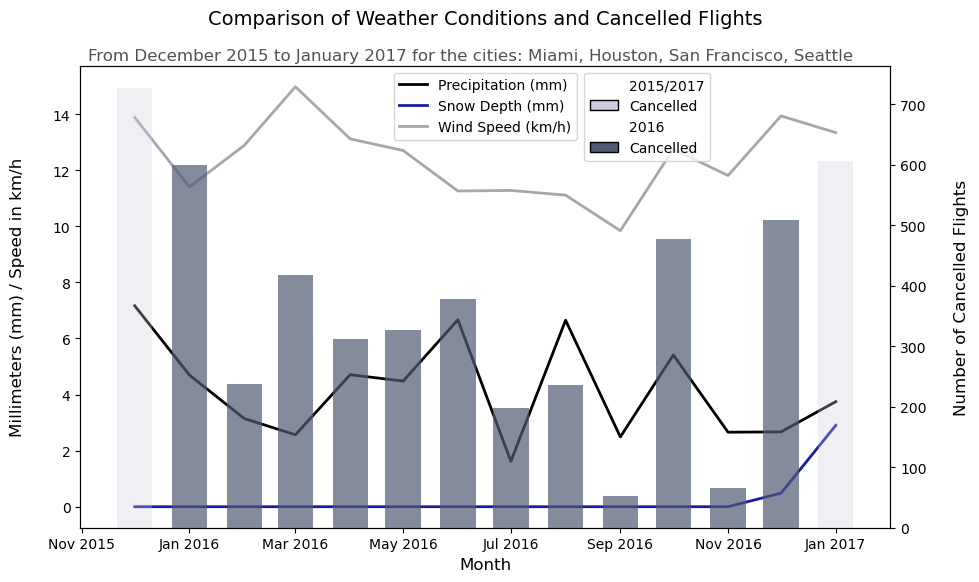

In [24]:
# Filter for the 4 main cities
main_cities = [
    "Miami, FL",
    "Houston, TX",
    "San Francisco, CA",
    "Seattle, WA"
]
main_cities_weather = weather_full[weather_full['city_name'].isin(main_cities)]

# Group by month and calculate average weather conditions for the main cities
monthly_avg_weather = main_cities_weather.groupby(main_cities_weather['date'].dt.to_period('M')).mean()

# Extract month and year from the date column
monthly_avg_weather.reset_index(inplace=True)
monthly_avg_weather['date'] = monthly_avg_weather['date'].dt.to_timestamp()  # Convert to datetime

# Merge with cancelled flights data
monthly_data = pd.merge(monthly_avg_weather, monthly_counts, left_on=['year', 'month'], right_on=['year', 'month'], how='outer')

# Sort monthly_data by year and month
monthly_data.sort_values(['year', 'month'], inplace=True)

# Plotting the figure
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting weather data on the left y-axis
weather_lines = []
weather_labels = []
weather_lines.append(ax1.plot(monthly_data['date'], monthly_data['preciptation_mm'], color='#000', linewidth=2.0)[0])
weather_labels.append('Precipitation (mm)')
weather_lines.append(ax1.plot(monthly_data['date'], monthly_data['snowdepth_mm'], color='#171d9f', linewidth=2.0)[0])
weather_labels.append('Snow Depth (mm)')
weather_lines.append(ax1.plot(monthly_data['date'], monthly_data['avg_windspeed_kmh'], color='#A3A8AE', linewidth=2.0)[0])
weather_labels.append('Wind Speed (km/h)')

# Setting the left y-axis label and limits
ax1.set_ylabel('Millimeters (mm) / Speed in km/h', fontsize=12, labelpad=20)

# Creating a twin Axes sharing the x-axis for cancelled flights data on the right y-axis
ax2 = ax1.twinx()

# Plotting cancelled flights data with wider bars
bar_width = 20  # Adjust the width of the bars as needed

# Plot bars for each year separately with different alpha values
flight_bars = []
flight_labels = []
for year, group in monthly_data.groupby('year'):
    color = '#505a74' if year == 2016 else '#cccddd'
    alpha = 0.7 if year == 2016 else 0.3
    flight_bars.append(ax2.bar(group['date'], group['cancelled'], width=bar_width, color=color, alpha=alpha)[0])
    flight_labels.append(str(year))

# Setting the right y-axis label
ax2.set_ylabel('Number of Cancelled Flights', fontsize=12, labelpad=20)

# Set x-axis label
ax1.set_xlabel('Month', fontsize=12)

# Formatting x-ticks to show only month and year
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Using mdates

# Title
plt.title('Comparison of Weather Conditions and Cancelled Flights', fontsize=14, pad=30)
plt.suptitle('From December 2015 to January 2017 for the cities: Miami, Houston, San Francisco, Seattle', color='#4E5356', y=0.91, x=0.45)

# Create custom legend
legend_elements = [
    Patch(facecolor='none', edgecolor='none', label='2015/2017'),  # Title for 2015/2017
    Patch(facecolor='#cccddd', edgecolor='black', label='Cancelled'),
    Patch(facecolor='none', edgecolor='none', label='2016'),  # Title for 2016
    Patch(facecolor='#505a74', edgecolor='black', label='Cancelled'),
]

# Combine weather and flights legends
weather_legend = ax1.legend(weather_lines, weather_labels, loc='upper center', bbox_to_anchor=(0.5, 1))
flight_legend = ax2.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.7, 1))

# Adjust layout to make room for legends
plt.subplots_adjust(right=0.8)

# Show plot
plt.show()
